In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from neural_networks_from_scratch.models.mlp import MLP
from neural_networks_from_scratch.training.loss_functions import mean_squared_error
from neural_networks_from_scratch.training.model_training import train_model

In [3]:
import random
random.seed(0)

In [4]:
n_features = 2
n_outputs = 1


# Define a simple surface of y values for given x1 and x2 values.
# y = x1 + x2 is the function that should be learned by the model
data =  [
    [[0.0, 0.0], 0.0],
    [[0.0, 1.0], 1.0],
    [[1.0, 0.0], 1.0],
    [[1.0, 1.0], 2.0],
    [[0.0, 2.0], 2.0],
    [[2.0, 0.0], 2.0],
    [[2.0, 2.0], 4.0],
]

x = [x_ for x_, y_ in data]
y_true = [y_ for x_, y_ in data]

grid_x, grid_y = np.mgrid[-10:10:200j, -10:10:200j]  # for plotting

In [5]:
def run(train_steps, record_steps=None, plot=True):
    model = MLP(
        n_inputs=n_features,
        layers=(4, 4, n_outputs),
    )

    loss, train_df = train_model(
        model=model,
        x=x,
        y_true=y_true,
        train_steps=int(train_steps),
        record_steps=record_steps,
        learning_rate=1e-2,
        learning_rate_decay=0.5,
        loss_function=mean_squared_error,
        plot=plot,
    )
    plt.show()

    loss.set_track_gradients_full_network(False) # stop tracking gradients, only doing inference now



    grid_x, grid_y = np.mgrid[-10:10:200j, -10:10:200j]
    x1_vals = np.arange(-10, 10, 0.1)
    x2_vals = np.arange(-10, 10, 0.1)
    a_mesh, b_mesh = np.meshgrid(x1_vals, x2_vals)
    combinations = np.vstack([a_mesh.ravel(), b_mesh.ravel()]).T
    data_df = pd.DataFrame(combinations, columns=["x1", "x2"])
    data_df["y_true"] = data_df["x1"] + data_df["x2"]

    data_df["y_pred"] = [y_.to_gvariable().val for y_ in model.forward(data_df[["x1", "x2"]].to_numpy().tolist())]
    data_df["y_error"] = data_df["y_true"] - data_df["y_pred"]

    for col in ["y_pred", "y_error"]:
        print(f"{col=}")
        grid_hue = griddata((data_df["x1"], data_df["x2"]), data_df[col], (grid_x, grid_y), method='cubic')

        plt.figure(figsize=(8, 6))
        contour = plt.contourf(grid_x, grid_y, grid_hue, levels=100, cmap="viridis")
        plt.colorbar(contour, label=col)
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.axhline(0, color='black', linestyle="--")
        plt.axhline(2, color='black', linestyle="--")
        plt.axvline(0, color='black', linestyle="--")
        plt.axvline(2, color='black', linestyle="--")
        plt.show()
    
    print(f'MAE total= {data_df["y_error"].abs().mean()}')
    data_df_ = data_df[
        (data_df["x1"] >= 0) & 
        (data_df["x1"] <= 2) & 
        (data_df["x2"] >= 0) & 
        (data_df["x2"] <= 2)
    ]
    print(f'MAE in train region = {data_df_["y_error"].abs().mean()}')
    data_df_ = data_df[
        (data_df["x1"] < 0) | 
        (data_df["x1"] > 2) | 
        (data_df["x2"] < 0) | 
        (data_df["x2"] > 2)
    ]
    print(f'MAE out of train region = {data_df_["y_error"].abs().mean()}')
    
    return model

/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


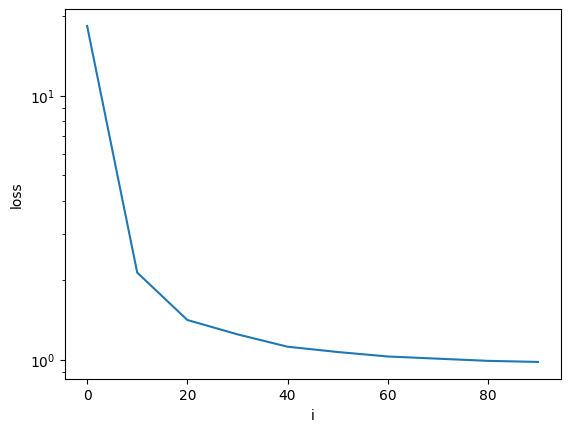

col='y_pred'


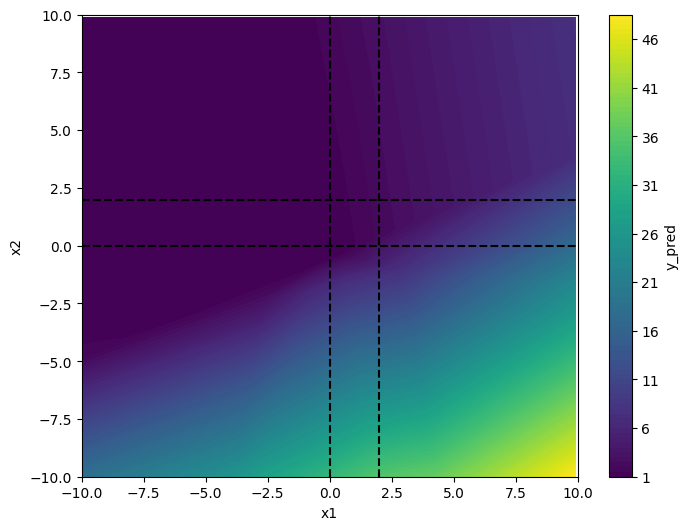

col='y_error'


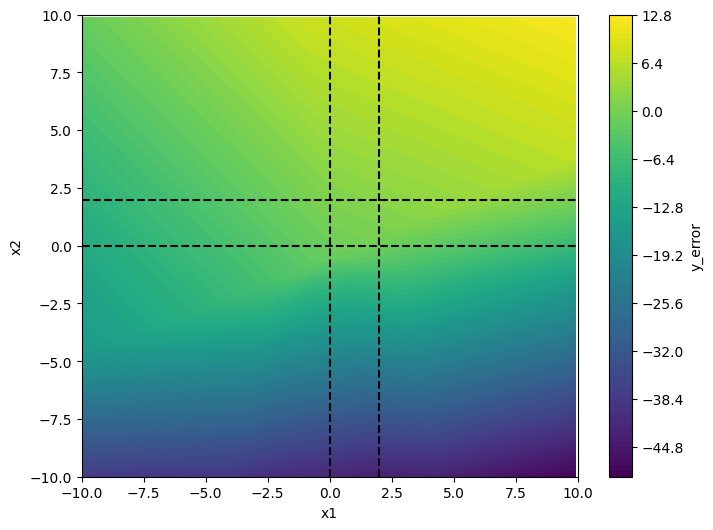

MAE total= 13.381837027605675
MAE in train region = 0.6499008307774141
MAE out of train region = 13.510442443735252


In [6]:
_ = run(train_steps=100, record_steps=10, plot=True)

Looks to have not been enough training steps. Let's try again differing number of steps.

train_steps=100
col='y_pred'


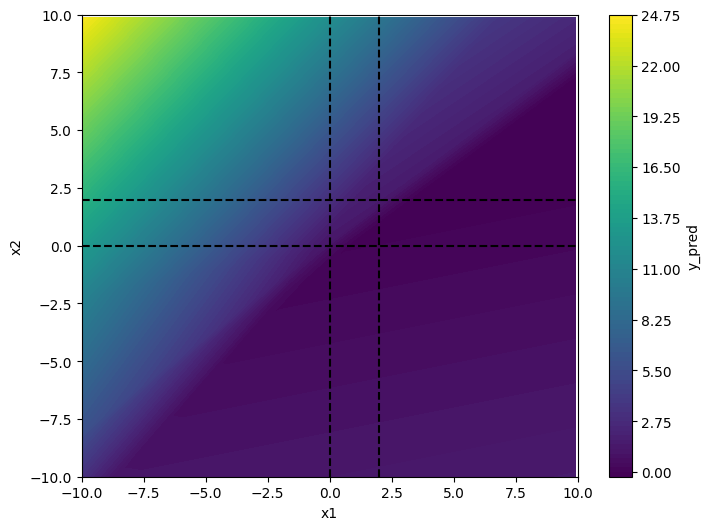

col='y_error'


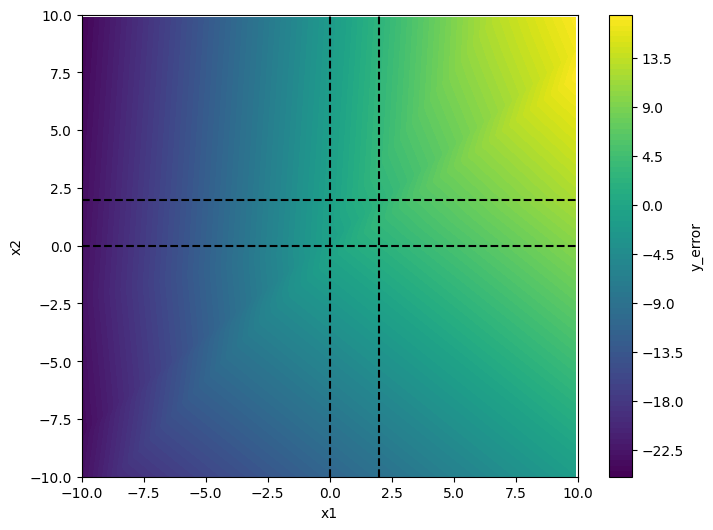

MAE total= 9.354806317231192
MAE in train region = 1.2114663069265799
MAE out of train region = 9.437062276931242




train_steps=1000
col='y_pred'


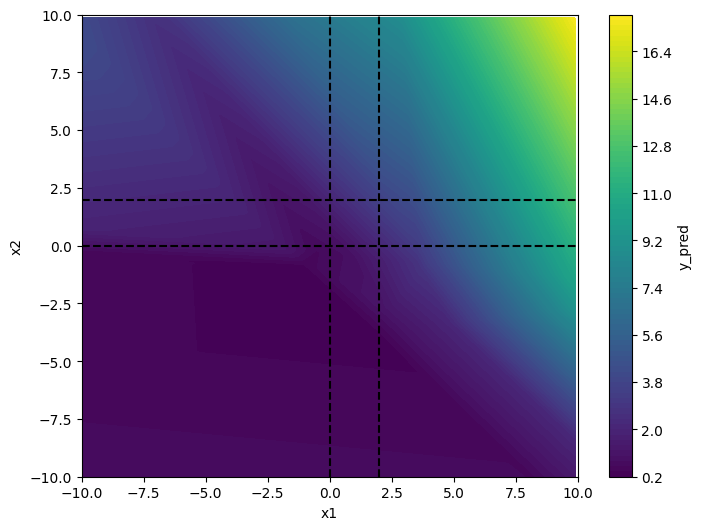

col='y_error'


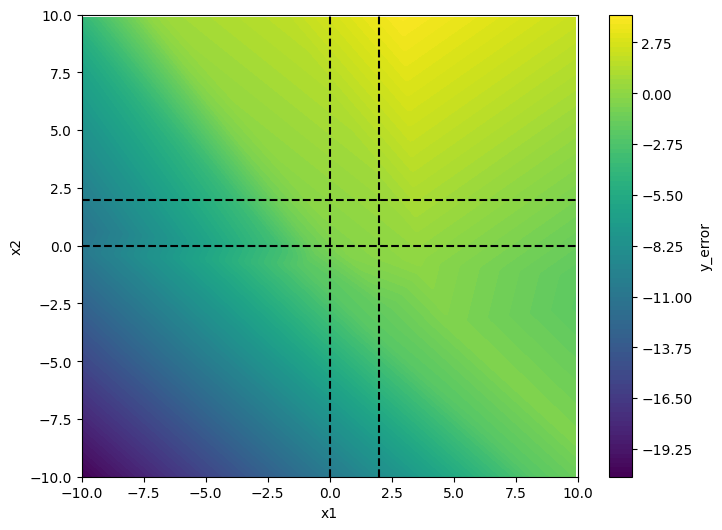

MAE total= 4.483812382289513
MAE in train region = 0.16537924430362821
MAE out of train region = 4.527432919036845




train_steps=10000.0
col='y_pred'


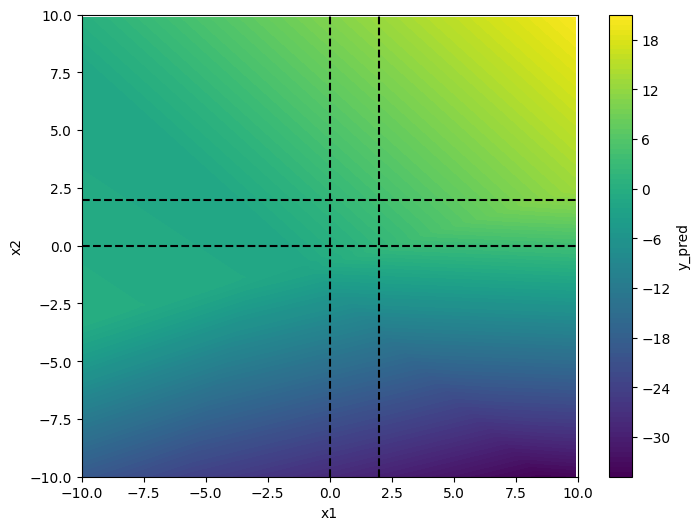

col='y_error'


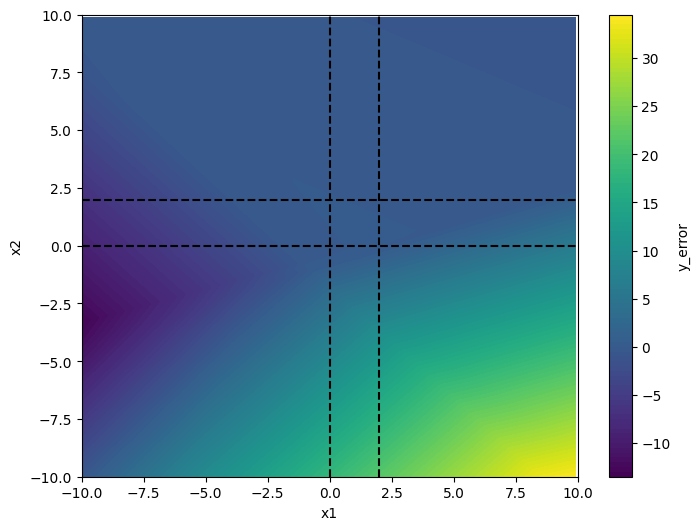

MAE total= 5.672004471397286
MAE in train region = 0.03518289583306361
MAE out of train region = 5.728942063069652




train_steps=100000.0
col='y_pred'


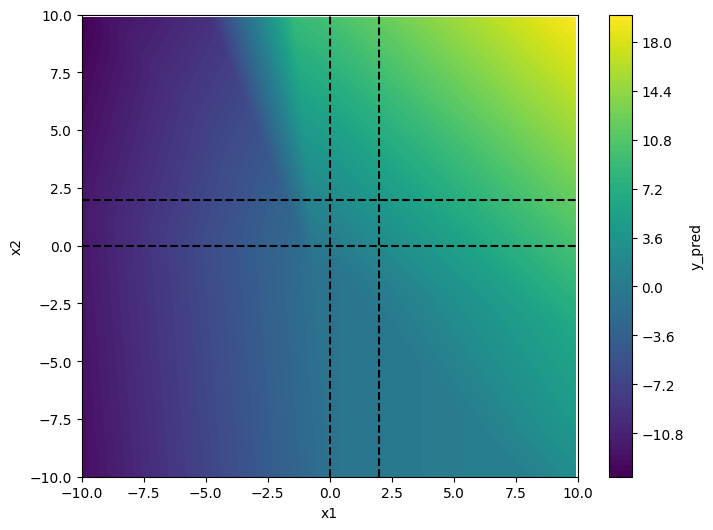

col='y_error'


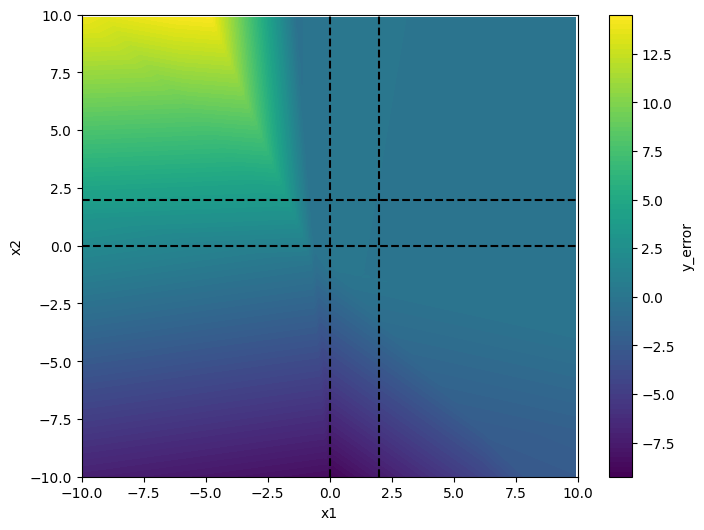

MAE total= 2.8548928562096085
MAE in train region = 0.002306193496185515
MAE out of train region = 2.8837068629036837






In [7]:
for train_steps in [100, 1000, 1e4, 1e5]:
    print(f"{train_steps=}")
    model = run(train_steps=train_steps, plot=False)
    print("\n\n\n")

OK so as expected, with enough training steps we do very well within the space of the training data
Interestingly:
- We don't just we well at the training data points, but interpolate between them very well
- We do very well in the whole domain of positive x1 *and* positive x2, even far from the training region.
- We do relatively badly for negavtive x1.
- But interestingly we do ok for negative x2 and positive x1. I would have expected some more similarity to the behaviour of negative x1 and positive x2

This worked better than expected with my very basic training code. It is a very simple function we are modelling after all.